In [18]:
import os
import sys
import pandas as pd
import yaml 
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from matplotlib import colors as mcolors
from matplotlib import patches as mpatches
import statsmodels.api as sm
import numpy as np
from itertools import product
import subprocess
import networkx as nx
import json

with open("../../config.yaml.local", "r") as f:
    LOCAL_CONFIG = yaml.safe_load(f)
#with open("../../config.yaml", "r") as f:
#    CONFIG = yaml.safe_load(f)
sys.path.append("../python")

import globals
import data_tools as dt

LOCAL_PATH = LOCAL_CONFIG["LOCAL_PATH"]
RAW_DATA_PATH = LOCAL_CONFIG["RAW_DATA_PATH"]
DATA_PATH = LOCAL_CONFIG["DATA_PATH"]
R_PATH = LOCAL_CONFIG["R_PATH"]

RUN_R_SCRIPTS = False
OVERWRITE = False

SUB_COLORS = {
    'bitcoin': 'orange',
    'econ': 'green',
    'meta': 'blue',
    'booksandarticles': 'lime',
    'ai': 'purple',
    'lightning': 'yellow',
    'stacker_sports': 'red',
    'tech': 'tab:purple',
    'agora': 'lightblue',
    'bitcoin_beginners': 'cyan',
    'design': 'pink'
}


In [19]:
posts = dt.get_posts(overwrite=OVERWRITE)
posts['subName'] = posts['subName'].fillna('none')

In [20]:
selector = (posts['text'].notnull()) & \
           (posts['text'].str.len() > 0) & \
           (posts['invoiceActionState'] != 'FAILED')
posts = posts.loc[selector].reset_index(drop=True)
posts['num_internal_links'] = posts['text'].apply(
    lambda x: len(dt.extract_internal_links(x))
)
posts_w_links = posts.loc[posts['num_internal_links']>0].reset_index(drop=True)

In [21]:
# create graph

DG = nx.DiGraph()
for idx, row in posts_w_links.iterrows():
    source_id = int(row['itemId'])
    source_user = row['userId']
    source_title = row['title']
    source_sub = row['subName']
    source_link = f"https://stacker.news/items/{source_id}"
    internal_links = dt.extract_internal_links(row['text'])
    for dest_id in [int(item) for item in internal_links]:
        destrow = posts.loc[posts['itemId']==dest_id]
        if (not destrow.empty) and (dest_id != source_id):
            dest_user = destrow['userId'].values[0]
            dest_title = destrow['title'].values[0]
            dest_sub = destrow['subName'].values[0]
            dest_link = f"https://stacker.news/items/{dest_id}"
            DG.add_node(source_id, title=source_title, territory=source_sub, link=source_link)
            DG.add_node(dest_id, title=dest_title, territory=dest_sub, link=dest_link)
            DG.add_edge(source_id, dest_id)

print(f"Number of nodes: {DG.number_of_nodes()}")
print(f"Number of edges: {DG.number_of_edges()}")

Number of nodes: 14797
Number of edges: 33649


In [22]:
# Get the subs
subs = set(nx.get_node_attributes(DG, 'territory').values())
subsdf = []
for sub in subs:
    subsdf.append({
        'sub': sub,
        'num_nodes': len([n for n, attr in DG.nodes(data=True) if attr.get('territory') == sub]),
        'color': SUB_COLORS.get(sub, 'gray')
    })
subsdf = pd.DataFrame(subsdf)
subsdf['zorder'] = subsdf['color'].apply(lambda x: 0 if x == 'gray' else 1)
subsdf = subsdf.sort_values(by= ['zorder', 'num_nodes'], ascending=[True, False]).reset_index(drop=True)


In [23]:
# Node with most incoming links
max_in_degree_node = max(DG.in_degree, key=lambda x: x[1])
print(f"Node with most incoming links: {max_in_degree_node[0]} with {max_in_degree_node[1]} links")

Node with most incoming links: 410853 with 135 links


In [24]:
# Node with most outgoing links
max_out_degree_node = max(DG.out_degree, key=lambda x: x[1])
print(f"Node with most outgoing links: {max_out_degree_node[0]} with {max_out_degree_node[1]} links")

Node with most outgoing links: 1214495 with 167 links


In [25]:
# weakly connected commponents

components = sorted(nx.weakly_connected_components(DG), key=len, reverse=True)
subgraphs = [DG.subgraph(c).copy() for c in components]
print(f"Number of weakly connected components: {len(subgraphs)}")
print(f"Size of largest component: {len(subgraphs[0].nodes())} nodes, {len(subgraphs[0].edges())} edges")

Number of weakly connected components: 1153
Size of largest component: 11745 nodes, 31291 edges


In [26]:
# SFDP point positions
myG = subgraphs[0]  # largest component
pos = nx.nx_agraph.graphviz_layout(myG, prog='sfdp')


In [27]:
# spiral the positions for nicer looking plot

xcoords = [x for x, y in pos.values()]
ycoords = [y for x, y in pos.values()]
centroid = (np.mean(xcoords), np.mean(ycoords))
dist = {
    n: np.sqrt((x - centroid[0])**2 + (y - centroid[1])**2)
    for n, (x, y) in pos.items()
}
dists = [d for d in dist.values()]
#R = np.quantile(dists, 0.99)
R = 0
maxdist = max(dists)
spiral_pos = {}
for p, (x, y) in pos.items():
    d = dist[p]
    if d <= R:
        spiral_pos[p] = (x - centroid[0], y - centroid[1])
    else:
        frac = (d - R) / (maxdist - R)
        new_dist = (d - R)**(1/3) + R
        theta = np.pi*2*frac**4
        dx = x - centroid[0]
        dy = y - centroid[1]
        norm = np.sqrt(dx**2 + dy**2)
        ux = dx / norm
        uy = dy / norm
        cos_t = np.cos(theta)
        sin_t = np.sin(theta)
        rx = cos_t*ux - sin_t*uy
        ry = sin_t*ux + cos_t*uy
        new_x = new_dist*rx
        new_y = new_dist*ry
        spiral_pos[p] = (new_x, new_y)


In [ ]:
# dump graph info to json file
nodes = []
for n, data in myG.nodes(data=True):
    x, y = spiral_pos[n]
    item = {
        "data": {"id": str(n), **{k: v for k, v in data.items()}},
        "position": {"x": float(x*50), "y": float(y*50)}
    }
    nodes.append(item)
edges = []
for i, (u, v, edata) in enumerate(myG.edges(data=True)):
    e = {
        "data": {
            "id": f"{u}->{v}:{i}",
            "source": str(u),
            "target": str(v),
            **{k: v for k, v in edata.items()}
        }
    }
    edges.append(e)

meta = {
    "directed": True,
    "node_count": myG.number_of_nodes(),
    "edge_count": myG.number_of_edges()
}

with open("sn-knowledge-graph.json", "w", encoding="utf-8") as f:
    json.dump({"nodes": nodes, "edges": edges, "meta": meta}, f)

In [29]:
print(max([y for n, (x, y) in spiral_pos.items()]))
print(min([y for n, (x, y) in spiral_pos.items()]))

10.892970689128111
-11.14940396838355


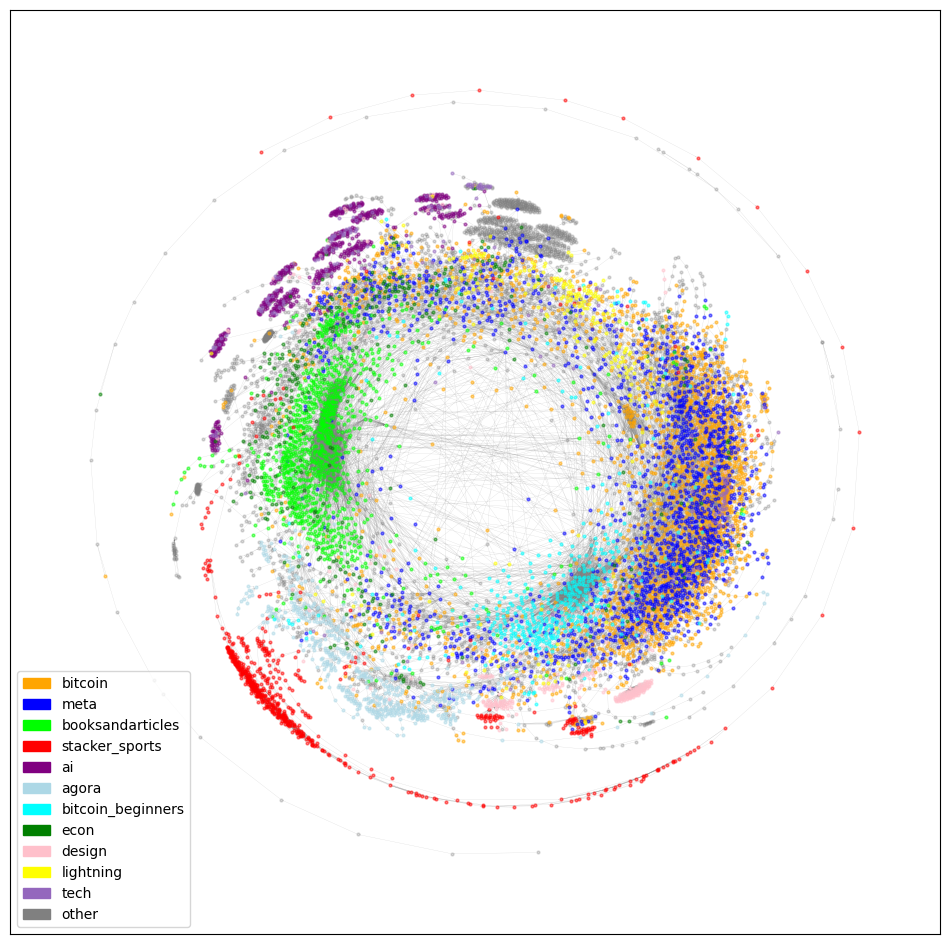

In [30]:
plt.figure(figsize=(12, 12))
handles = []
for idx, row in subsdf.iterrows():
    sub = row['sub']
    nodes = [n for n, attr in myG.nodes(data=True) if attr.get('territory') == sub]
    if len(nodes) == 0:
        continue
    if row['color'] == 'gray':
        alpha = 0.3
        label = None
        zorder = 0
    else:
        alpha = 0.5
        label = sub
        handles.append(mpatches.Patch(color=row['color'], label=sub))
    nx.draw_networkx_nodes(
        myG, spiral_pos, 
        nodelist=nodes,
        node_color=row['color'],
        node_size=4,
        alpha=alpha,
        label=label
    )
nx.draw_networkx_edges(
    myG, spiral_pos, 
    edge_color = 'gray',
    width = 0.2,
    alpha = 0.3,
    node_size=4,
    arrowsize=1
)
handles.append(mpatches.Patch(color='gray', label='other'))

plt.legend(handles=handles, loc='lower left')
plt.show()


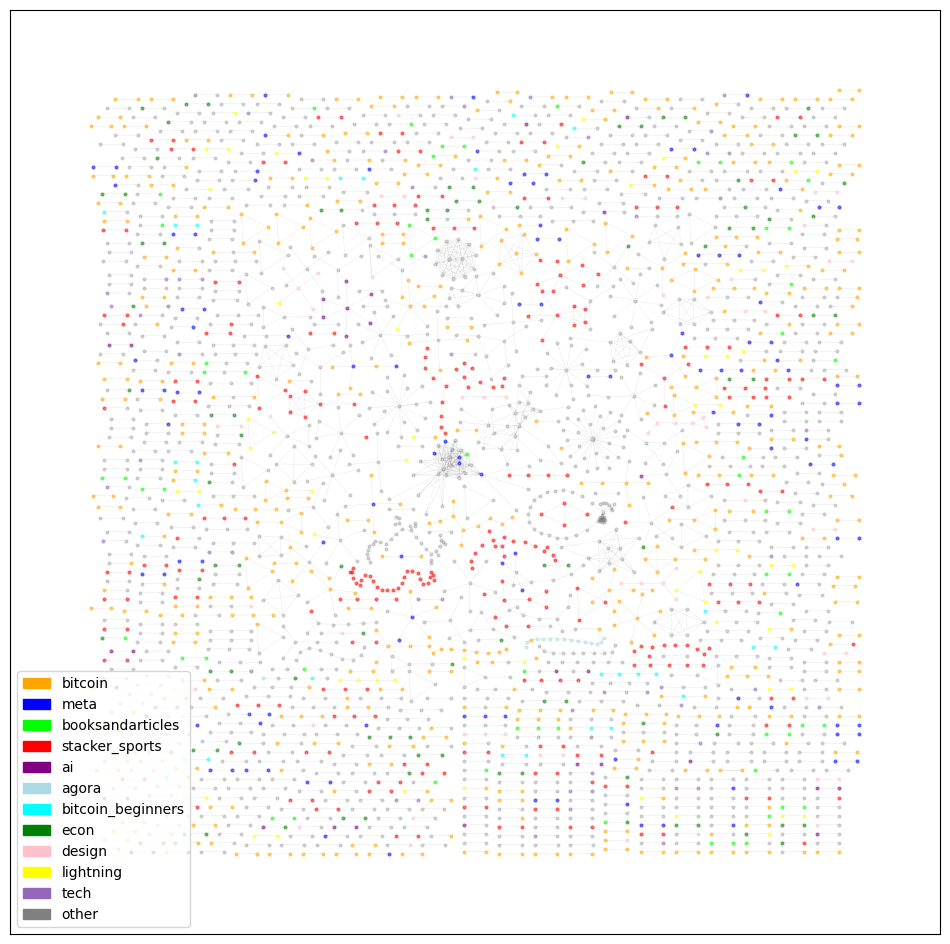

In [31]:
myG = nx.compose_all(subgraphs[1:])  # all other components

pos = nx.nx_agraph.graphviz_layout(myG, prog='sfdp')

plt.figure(figsize=(12, 12))
handles = []
for idx, row in subsdf.iterrows():
    sub = row['sub']
    nodes = [n for n, attr in myG.nodes(data=True) if attr.get('territory') == sub]
    if len(nodes) == 0:
        continue
    if row['color'] == 'gray':
        alpha = 0.3
        label = None
        zorder = 0
    else:
        alpha = 0.5
        label = sub
        handles.append(mpatches.Patch(color=row['color'], label=sub))
    nx.draw_networkx_nodes(
        myG, pos, 
        nodelist=nodes,
        node_color=row['color'],
        node_size=4,
        alpha=alpha,
        label=label
    )
nx.draw_networkx_edges(
    myG, pos, 
    edge_color = 'gray',
    width = 0.2,
    alpha = 0.3,
    node_size=4,
    arrowsize=1
)
handles.append(mpatches.Patch(color='gray', label='other'))

plt.legend(handles=handles, loc='lower left')
plt.show()